In [ ]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import eli5
from eli5.sklearn import PermutationImportance
import scipy
from scipy.cluster import hierarchy as hc
from lime.lime_tabular import LimeTabularExplainer
import math
import xai
import alibi

params = {
          "ytick.color" : "w",
          "xtick.color" : "w",
          "text.color": "white",
          'figure.facecolor': "#384151",
          'legend.facecolor': "#384151",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          'font.size': '20.0',
          'figure.figsize': [20, 7],
    }

plt.rcParams.update(params)


shap.initjs()
  

label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

def prepare_data(df):
    
    if "fnlwgt" in df: del df["fnlwgt"]
    
    tmp_df = df.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(tmp_df.dtypes.index, map(str, tmp_df.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            tmp_df[k] = tmp_df[k].astype(np.float32)
            tmp_df[k] -= tmp_df[k].mean()
            tmp_df[k] /= tmp_df[k].std()

    cat_columns = tmp_df.select_dtypes(['object']).columns
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('category')
    tmp_df[cat_columns] = tmp_df[cat_columns].apply(lambda x: x.cat.codes)
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('int8')
    
    return tmp_df

def get_dataset_1():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(100) if x["loan"].iloc[0] else x.sample(7_900)) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return tmp_df, df_display.copy()

def get_production_dataset():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(50) if x["loan"].iloc[0] else x.sample(60)) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return X, y


def get_dataset_2():
    tmp_df = df.copy()
    tmp_df_display = df_display.copy()
#     tmp_df_display[label_column] = tmp_df_display[label_column].astype(int).values
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_display = tmp_df_display.drop(label_column, axis=1).copy()
    y_display = tmp_df_display[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, tmp_df, tmp_df_display
    
df_display = pd.read_csv(csv_path, names=csv_columns)
df_display[label_column] = df_display[label_column].apply(lambda x: ">50K" in x)
df = prepare_data(df_display)

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(df[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

def plot_roc(y, probs):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.rcParams.update(params)
    plt.show()
    
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
def keras_score(self, X, y, **kwargs):
    """ Scorer class for eli5 library on feature importance"""
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

class ModelWrapper():
    """ Keras model wrapper to override the predict function"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])

def plot_all_features(X, plot_numeric=True, hist=True, dropna=False):
    fig = plt.figure(figsize=(20,15))
    cols = 5
    rows = math.ceil(float(X.shape[1]) / cols)
    for i, column in enumerate(X.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if X.dtypes[column] == np.object:
            X[column].value_counts().plot(kind="bar", axes=ax)
        elif plot_numeric:
            if hist:
                X[column].hist(axes=ax)
                plt.xticks(rotation="vertical")
            else:
                if dropna:
                    X[column].dropna().plot()
                else:
                    X[column].plot()
                    
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    
def plot_dendogram(corr, X):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(16,5))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16)
    plt.show()
    
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs    


import alibi
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

alibi_data, alibi_labels, alibi_feature_names, alibi_category_map = alibi.datasets.adult()

def get_alibi_data():
    
    # define train and test set
    np.random.seed(0)
    data_perm = np.random.permutation(np.c_[alibi_data, alibi_labels])
    data = data_perm[:, :-1]
    labels = data_perm[:, -1]

    idx = 30000
    X_train, y_train = data[:idx, :], labels[:idx]
    X_test, y_test = data[idx + 1:, :], labels[idx + 1:]

    # feature transformation pipeline
    ordinal_features = [x for x in range(len(alibi_feature_names)) if x not in list(alibi_category_map.keys())]
    ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scaler', StandardScaler())])

    categorical_features = list(alibi_category_map.keys())
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                                   ('cat', categorical_transformer, categorical_features)])


    np.random.seed(0)
    clf = RandomForestClassifier(n_estimators=50)

    alibi_loan_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', clf)])

    alibi_loan_model.fit(X_train, y_train)
    
    return X_train, X_test, y_train, y_test, \
        alibi_category_map, alibi_feature_names, alibi_loan_model

X_train_alibi, X_test_alibi, y_train_alibi, y_test_alibi, \
    category_map_alibi, feature_names_alibi, loan_model_alibi = get_alibi_data()


import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from alibi.explainers import CounterFactual

# def cnn_model():
#     from tensorflow.keras import backend as K
#     from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
#     from tensorflow.keras.models import Model
#     x_in = Input(shape=(28, 28, 1))
#     x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
#     x = MaxPooling2D(pool_size=2)(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
#     x = MaxPooling2D(pool_size=2)(x)
#     x = Dropout(0.3)(x)
#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     x_out = Dense(10, activation='softmax')(x)
#     cnn = Model(inputs=x_in, outputs=x_out)
#     cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return cnn

# cnn = cnn_model()
# cnn.summary()
# cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
# cnn.save('mnist_cnn.h5')

def show_iterations(explanation, max_lam_steps=10):
    n_cfs = np.array([len(explanation['all'][iter_cf]) for iter_cf in range(max_lam_steps)])
    examples = {}
    for ix, n in enumerate(n_cfs):
        if n>0:
            examples[ix] = {'ix': ix, 'lambda': explanation['all'][ix][0]['lambda'],
                           'X': explanation['all'][ix][0]['X']}
    columns = len(examples) + 1
    rows = 1

    fig = plt.figure(figsize=(16,6))

    for i, key in enumerate(examples.keys()):
        ax = plt.subplot(rows, columns, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(examples[key]['X'].reshape(28,28))
        plt.title(f'Iter {key}')

(cf_x_train, cf_y_train), (cf_x_test, cf_y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', cf_x_train.shape, 'y_train shape:', cf_y_train.shape)
plt.gray()

cf_x_train = cf_x_train.astype('float32') / 255
cf_x_test = cf_x_test.astype('float32') / 255
cf_x_train = np.reshape(cf_x_train, cf_x_train.shape + (1,))
cf_x_test = np.reshape(cf_x_test, cf_x_test.shape + (1,))
cf_y_train = to_categorical(cf_y_train)
cf_y_test = to_categorical(cf_y_test)

cf_xmin, cf_xmax = -.5, .5
cf_x_train = ((cf_x_train - cf_x_train.min()) / (cf_x_train.max() - cf_x_train.min())) * (cf_xmax - cf_xmin) + cf_xmin
cf_x_test = ((cf_x_test - cf_x_test.min()) / (cf_x_test.max() - cf_x_test.min())) * (cf_xmax - cf_xmin) + cf_xmin
        

# A practical guide towards explainability
# and bias evaluation in machine learning

<br>
<br>
<br>
<br>
<br>

<br>

<br>

<br>
<br>

<h2>Alejandro Saucedo</h2>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning
<br>
Director of ML Engineering, Seldon Technologies

<br>
<br>
<h3>Twitter: AxSaucedo</h3>
<br>
<h3>Slides: github.com/EthicalML/explainability-and-bias</h3>

<br><br><br>

<hr>


# Today

<br>
<br>

## 1) Hands on example: Company "Hype-ML" automating loan approval process 

<br>
<br>

## 2) Terminology + why it's not about "just removing bias"

<br>
<br>

## 3) Data Analysis

<br>
<br>

## 4) Model Evaluation


<br>
<br>

## 5) Production Monitoring

<br>

<br><br><br>

<hr>

# Hype-ML - A NEW Project has come in!

<br>

* Insurance company has a process where domain expert approves/rejects loan applications

<br>

* They receive over 1m applications and want to automate the process

<br>

# Business wants it NOW!

<br>

* They heard their competitor is using "Machine Learning" and business says we need to use that



<br><br><br>

<hr>

# The team had a look at how this worked

<br>

<img src="images/mlall.png" style="width:70vw">



<br><br><br>

<hr>

# The team asked for DATA

<br>
<br>

## Business gave them an excel sheet with 25 rows

<br>
<br>

The team pushed back, and after a while they finally got a dataset with ~8000 rows




<br><br><br>

<hr>

<br><br><br>


# And so it begun...

<br>

<img src="images/copypasta.jpg" style="height:50vh">

<br>
<br>

## The Hype-ML journey towards greatness...

<br><br><br>

<hr>

<br><br><br>

In [160]:
df_data, df_display = get_dataset_1()

df_display.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [161]:
X = df_data.drop(label_column, axis=1).copy()
y = df_data[label_column].astype(int).values.copy()

X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

print("Training size:", y_train.shape, "Testing size: ", y_valid.shape)

Training size: (6400,) Testing size:  (1600,)



<img src="images/train-test.png" style="width:70vw">

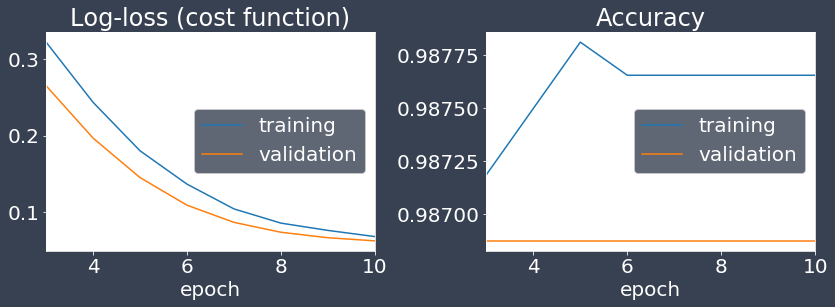

Log-loss (cost function):
training   (min:    0.068, max:    0.553, cur:    0.068)
validation (min:    0.062, max:    0.466, cur:    0.062)

Accuracy:
training   (min:    0.888, max:    0.988, cur:    0.988)
validation (min:    0.987, max:    0.987, cur:    0.987)


In [162]:
# 1 layer, 100 neurons model, with softmax (0-1 probabilities)
model = build_model(X)

model.fit(f_in(X_train), y_train, epochs=10,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)

In [163]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

1600/1600 [==============================] - 0s 47us/step
Error 0.0623: 
Accuracy 98.6875: 


# Accuracy is ~98%!

<br>
<br>
<br>
<br>

### What a better result on a Friday evening!

<br>
<br>
<br>

# Time for PROD?


<br><br><br>

<hr>

<br><br><br>


# We push to PROD!

<br>
<br>
<br>
<br>

### A few weeks go by...

<br>


<br><br><br>

<hr>

<br><br><br>


# BUZZFEED NEWS: HYPE-ML DEPLOYS RACIST SEXIST AI!!!!

<br>

<img src="images/layer.jpg" style="height: 50vh">


<br>


# ...but... but we followed the instructions in the internet!


<br><br><br>

<hr>

<br><br><br>


# Time to diagnose!

<br>
<br>

## We ask business to gather the 110 applications in production...

<br>
<br>

## ...and label it to understand what went wrong


<br><br><br>

<hr>

<br><br><br>

In [164]:
X_prod, y_prod = get_production_dataset()

print(X_prod.shape)
X_prod.head()

(110, 13)


,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0.177293,4,15,-0.031359,2,1,0,4,1,0.237140,-0.216656,-0.035429,39
1,-0.555822,4,9,1.134722,4,12,1,2,0,-0.145918,-0.216656,0.774456,39
2,-1.142313,4,8,0.357334,4,3,4,2,0,-0.145918,-0.216656,-0.035429,39
3,0.397227,4,12,1.523415,5,12,4,4,0,-0.145918,-0.216656,0.612479,39
4,-1.069002,4,15,-0.031359,4,13,1,4,0,-0.145918,-0.216656,-1.979153,39


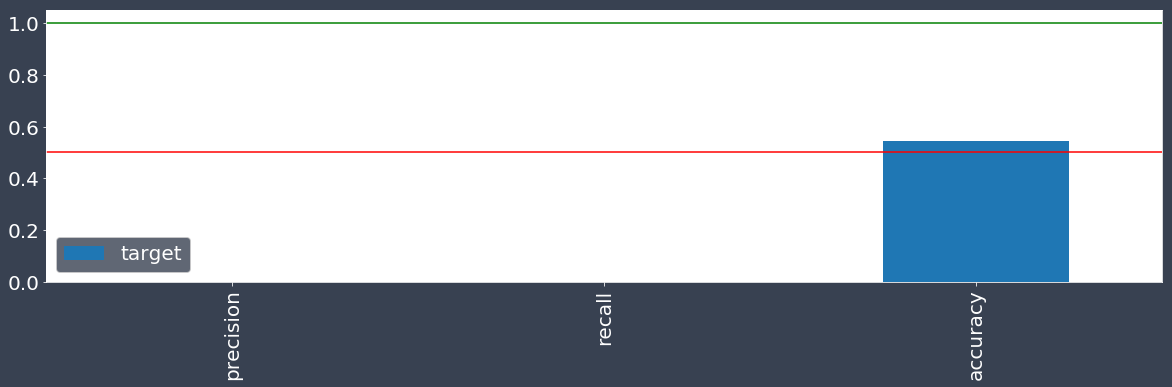

In [165]:
probabilities = model.predict(f_in(X_prod))
pred = f_out(probabilities)
_= xai.metrics_plot(pred, y_prod, exclude_metrics=["auc", "specificity", "f1"])

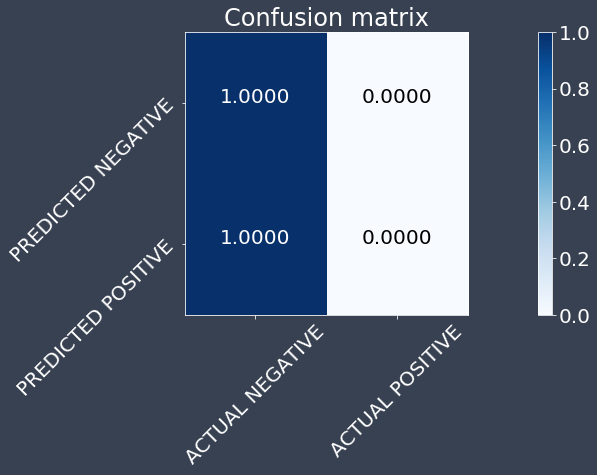

In [166]:
xai.confusion_matrix_plot(y_prod, pred)

[Text(0, 0, 'Rejected'), Text(0, 0, 'Approved')]

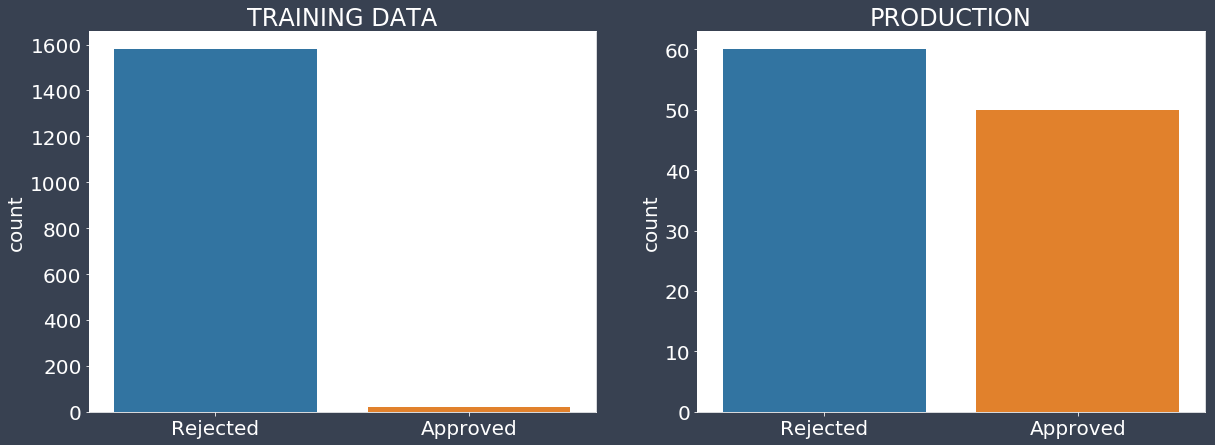

In [167]:
fig, ax = plt.subplots(1,2)
a = sn.countplot(y_valid, ax=ax[0]); a.set_title("TRAINING DATA"); a.set_xticklabels(["Rejected", "Approved"])
a = sn.countplot(y_prod, ax=ax[1]); a.set_title("PRODUCTION"); a.set_xticklabels(["Rejected", "Approved"])

# Undesired bias and explainability

<br>

<img src="https://i.imgflip.com/33o3on.gif" style="height: 50vh">

<br>

#### We have seen several examples where undesired biases have led to undesired results. In critical usecases, this may have impact of multiple generations.

<br><br><br>


<br><br><br>

# Undesired bias and explainability

<br>

* Has become popular due to several high profile incidents:

    * Amazon's "sexist" recruitment tool
    * Microsoft's "racist" chatbot
    * Negative discrimination in automated sentencing
    * Black box models + complex patterns can't be interpretable

<br>
<br>


## Organisations cannot take on unknown risks


# This challenge goes beyond the algorithms

<br>

### A large ethical decision should not just fall on the shoulders of a single data scientist

<br>

<img src="images/chart.png" style="height:30vw;margin-left: 10vw; float: left; background-color: transparent">
<img src="images/chart-more.png" style="height:30vw; margin-left: 10vw; float: left;  background-color: transparent">

<br><br><br>


<br><br><br>

# Who's ethics?
<br>

### An analysis of eastern and western philosophy, in respect to AI Ethics

<br>

<div style="float: left; width: 50%">
<img style="" src="images/philosophers.jpg">
</div>

<div style="float: left; width: 50%">
<img src="images/whos-ethics.jpg">
</div>

# Stages where bias can appear

<br>
<br>

## 1) Statistical bias (During the project)

##### Sub-optimal choices on decisions after project starts (models, metrics, human-in-the-loop, infrastructure design, etc)

<br>
<br>

## 2) A-priori bias (Before the project)

##### Limitations around the project that constrain the best possible outcome (limited time, budget, data, societal shifts in perception, etc)

<br><br>

# Not as easy as just "removing bias"

<br>
<br>

* Any non trivial decision holds a bias, without exceptions - unless you build a classifier that only predicts "maybe".
* It's impossible to "just remove bias" (as the whole purpose of ML is to discriminate towards the right answer)
* Societal bias carries an inherent bias - what may be "racist" for one person, may not be for another group or geography

<br>
<br>

#### Emphasis on last point: Societal bias is inherently biased

<br><br><br>

# What it's about: Mitigating undesired bias through process and explainability techniques

<br><br><br>

* Like in cybersecurity, it's impossible to build a system that will never be hacked
* But it's possible to build a system and introduce processes that ensure a reasonable level of security
* Similarly we want to introduce processes that allow us to remove a reasonable level of undesired biases
* This is going 0 to 1, trying to introduce a foundation for undesired bias

<br><br><br>


# Principles, Standards & Regulation

### github.com/EthicalML/awesome-artificial-intelligence-guidelines

<img src="images/guidelines.jpg">
<br>


# Remember our workflow? Let's add three new steps:

<br>

<img src="images/mlall.png" style="width=100vw">

# Augmenting the data science workflow

<br>

<img src="images/gml.png" style="width=100vw">


<br><br><br>

<hr>

<br><br><br>

## The explainability tradeoff


<br>

By making introducing processes that allow us to mitigate undesired bias and increase explainability, we face severall tradeoffs:


<br>

* More redtape introduced

<br>

* Potentially lower accuracy 

<br>

* Constrains on models that can be used

<br>

* Increase in infrastructure complexity

<br>

* Requirement of domain expert knowledge intersection

<br>

#### The amount of explainability and process is proportionate to the impact of the project (prototype vs prod)

# 1) Data Analysis

<br><br><br>

<hr>

<br><br><br>

# XAI - eXplainable AI 

<br>

## A set of tools to explain machine learning data

<br>

<img src="images/xai.jpg" style="width=100vw">

<br>

## https://github.com/EthicalML/XAI


<br><br><br>

<hr>

## Let's get the new training dataset

In [168]:
X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, df, df_display \
    = get_dataset_2()
df_display.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


## 1.1) Visualising complex data imbalances
#### We may be able to identify an imbalance of examples for a specific class

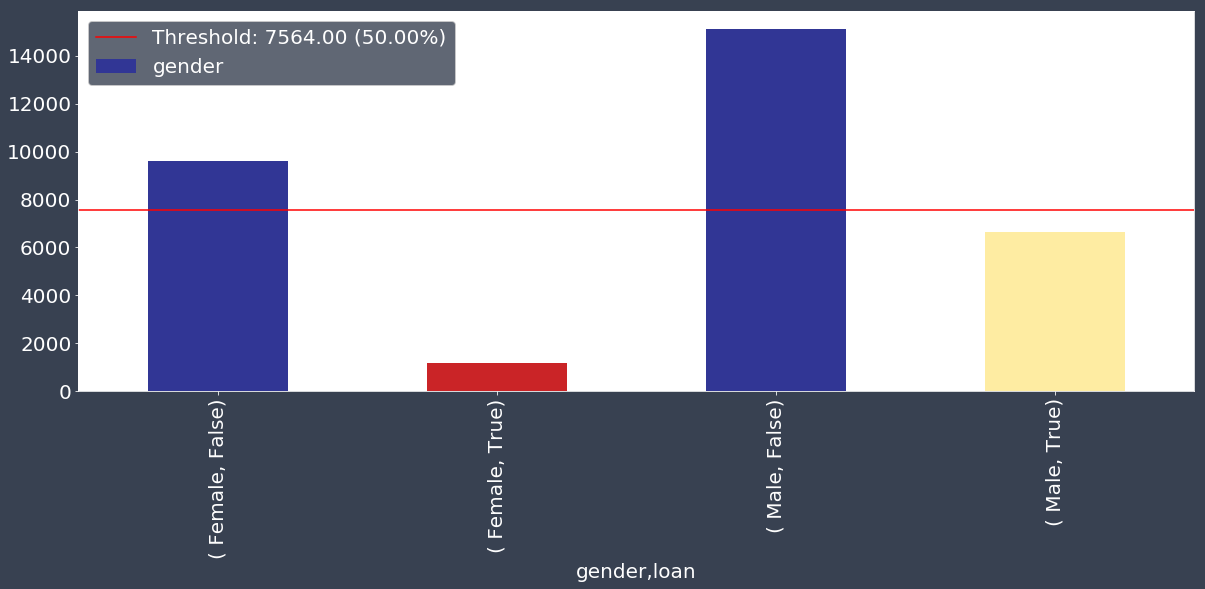

In [169]:
im = xai.imbalance_plot(df_display, "gender", "loan" , categorical_cols=["loan", "gender"])

## 1.2) Upsampling / Downsampling of data imbalances
#### We can re-balance the metrics for imbalanced datasets, but we need to understand what this actually means

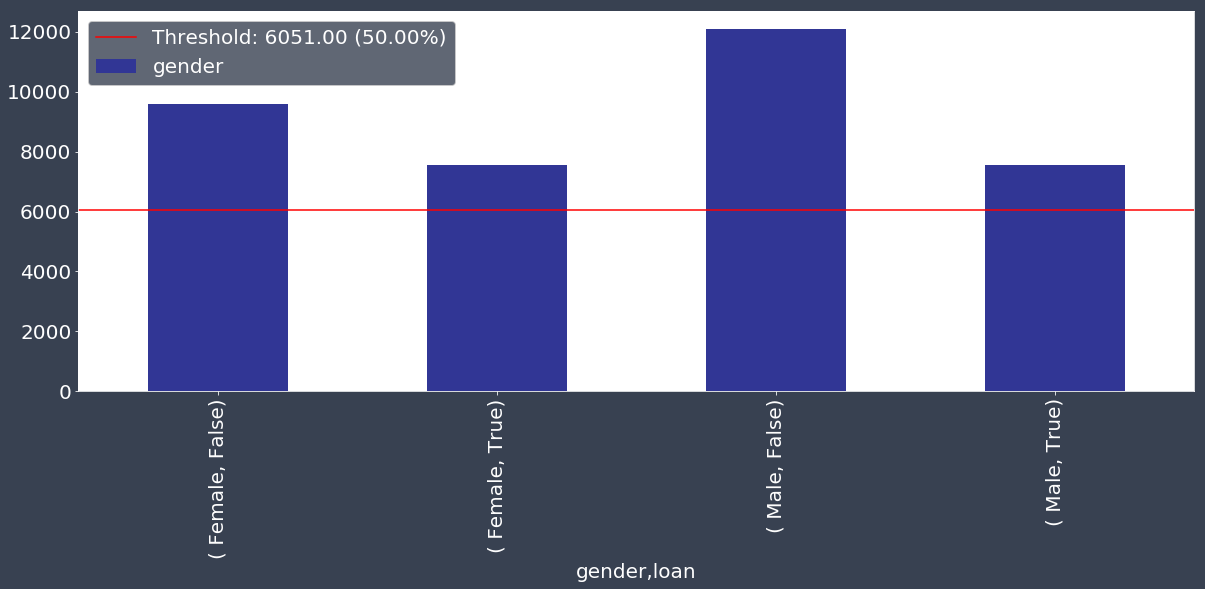

In [170]:
im = xai.balance(df_display, "gender", "loan", categorical_cols=["gender", "loan"],
                upsample=0.5, downsample=0.8)

## 1.2) Balanced testing / validation datasets

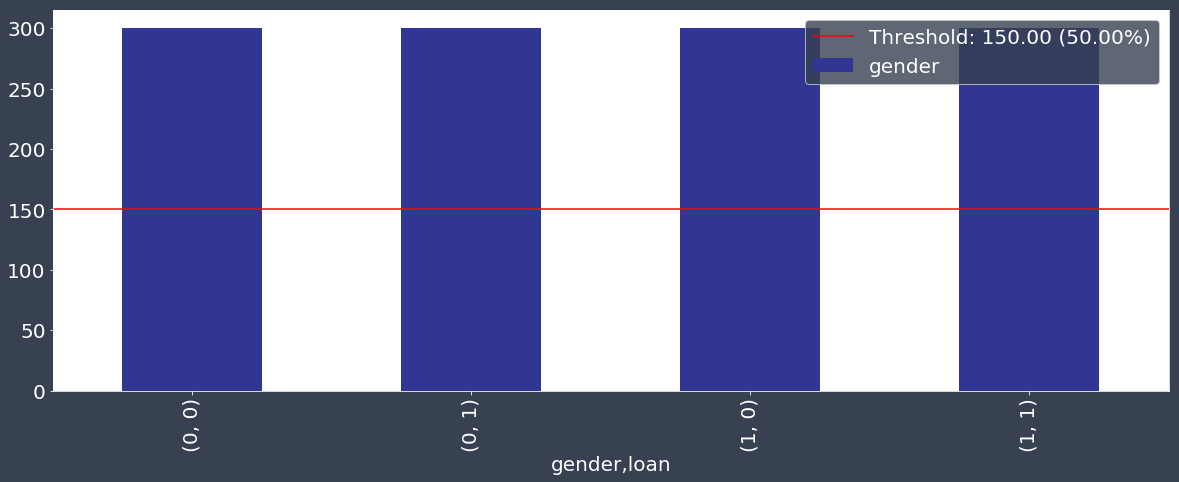

In [171]:
X_train_balanced, y_train_balanced, X_valid_balanced, y_valid_balanced, train_idx, test_idx = \
    xai.balanced_train_test_split(
            X, y, "gender", 
            min_per_group=300,
            max_per_group=300,
            categorical_cols=["gender", "loan"])

X_valid_balanced["loan"] = y_valid_balanced
im = xai.imbalance_plot(X_valid_balanced, "gender", "loan", categorical_cols=["gender", "loan"])

## 1.4 Correlations hidden in data
#### We can identify potential correlations across variables through a dendogram visualiation

/home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


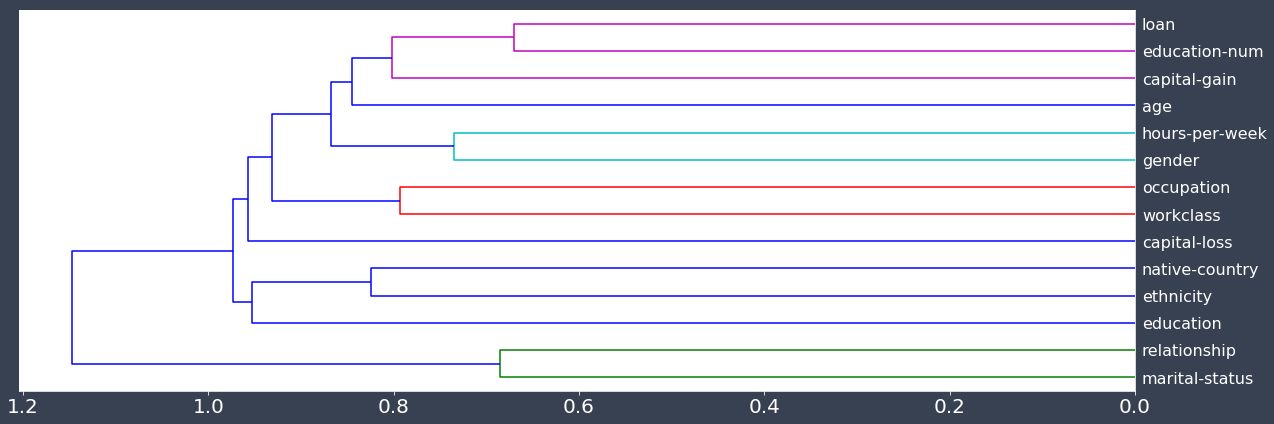

In [172]:
corr = xai.correlations(df_display, include_categorical=True)

## 1.5 Shoutout to other tools and techniques
https://github.com/EthicalML/awesome-production-machine-learning#industrial-strength-visualisation-libraries
![](images/dataviz.jpg)

# 2) Model evaluation

<br><br><br>

<hr>

<br><br><br>

# Alibi - Black Box Model Explanations

<br>

## A set of proven scientific techniques to explain ML models as black boxes

<br>

<img src="images/alibi-repo-new.jpg" style="width=100vw">

<br>

## https://github.com/SeldonIO/Alibi


<br><br><br>

<hr>

# Model Evaluation Metrics: White / Black Box

![](images/whiteblackbox.jpg)

# Model Evaluation Metrics: Global vs Local

![](images/globallocal.jpg)

# Local black box model evaluation metrics with Alibi

### Overview of methods

![](images/alibi-table.jpg)

# Anchors 

<br>

#### Consists of if-then rules, called the anchors, which sufficiently guarantee the explanation locally and try to maximize the area for which the explanation holds. (ArXiv: Anchors: High-Precision Model-Agnostic Explanations)

<br>

<div style="float: left; width: 50%">
<img src="images/textanchor.jpg">
</div>

<div style="float: left; width: 50%">
<img src="images/anchorimage.jpg">
</div>

## Let's first train our model with the new, more reasonable dataset

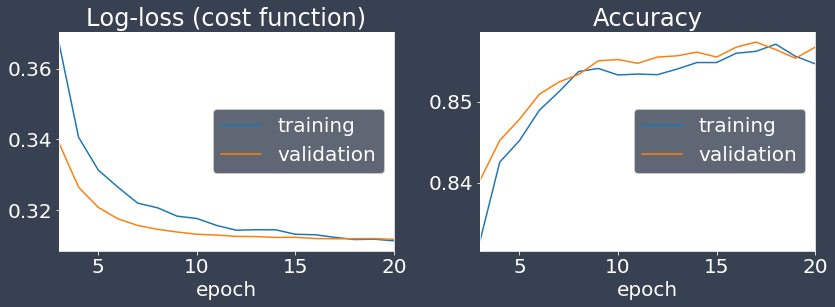

Log-loss (cost function):
training   (min:    0.311, max:    0.587, cur:    0.311)
validation (min:    0.312, max:    0.476, cur:    0.312)

Accuracy:
training   (min:    0.735, max:    0.857, cur:    0.855)
validation (min:    0.794, max:    0.857, cur:    0.857)


In [173]:
# Let's start by building our model with our newly balanced dataset
model = build_model(X)
model.fit(f_in(X_train), y_train, epochs=20, batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid), callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)
probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

## We can now use the Tabular Anchor technique in Alibi

In [174]:
from alibi.explainers import AnchorTabular

explainer = AnchorTabular(
    loan_model_alibi.predict, 
    feature_names_alibi, 
    categorical_names=category_map_alibi)

explainer.fit(
    X_train_alibi, 
    disc_perc=[25, 50, 75])

print("Explainer built")

Explainer built


In [175]:
X_test_alibi[:1] 

array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])

In [176]:
explanation = explainer.explain(X_test_alibi[:1], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.97
Coverage: 0.11


# Counterfactual Explanations

### The counterfactual explanation of an outcome or a situation Y takes the form “If X had not occured, Y would not have occured” 

![](images/counterfactuals7.jpg)

### We load a convolutional neural network
#### Explainability techniques work with any classifier

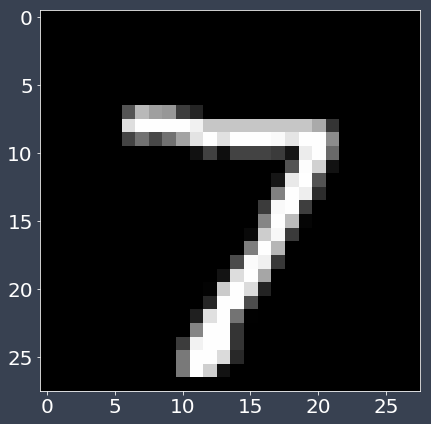

In [177]:
cnn = load_model('mnist_cnn.h5')
cf_X = cf_x_test[0].reshape((1,) + cf_x_test[0].shape)
plt.imshow(cf_X.reshape(28, 28));

### Build a counterfactual explanation
#### We can select the target class we want to aim for

Counterfactual prediction: 9 with probability [2.8820663e-12 3.0502541e-11 5.0862967e-09 2.1951721e-06 3.9167953e-05
 7.8527846e-06 2.6525455e-14 9.4558978e-05 7.3595431e-05 9.9978262e-01]


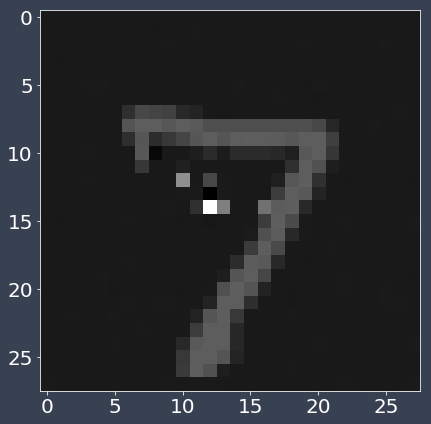

In [178]:
shape = (1,) + cf_x_train.shape[1:]
target_class = 9 # any class other than 7 will do

cf = CounterFactual(cnn, shape=shape, target_class=target_class, target_proba=1.0, max_iter=20)
explanation = cf.explain(cf_X)

print(f"Counterfactual prediction: {explanation['cf']['class']} with probability {explanation['cf']['proba'][0]}")
plt.imshow(explanation['cf']['X'].reshape(28, 28));

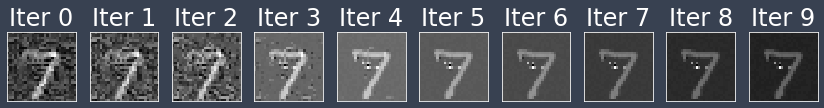

In [179]:
show_iterations(explanation)

# Improving computational efficiency

### Our Data Science team at Seldon published a paper that tackles the issue.

<img src="images/with-prototypes.jpg" style="height: 80vh">

### Intersection with Adversarial Robustness

<br>

* Black box explainability techniques allow us to understand black boxes

<br>

* But also provide tools that could be used maliciously

<br>

* Extra considerations need to be taken into account (i.e. when is a model "being explained")

<br>

* Limited access to explainability (auditors, domain experts, etc)

<br>


## 1.5 Shoutout to other tools and techniques
https://github.com/EthicalML/awesome-production-machine-learning#explaining-black-box-models-and-datasets
![](images/modevallibs.jpg)

# 3) Production Monitoring

<br><br><br>

<hr>

<br><br><br>

# Seldon Core - Production ML in K8s

<br>

## A language agnostic ML serving & monitoring framework in Kubernetes

<br>

<img src="images/seldon-core-repo.jpg" style="width=100vw">

<br>

## https://github.com/SeldonIO/seldon-core


<br><br><br>

<hr>

# Design patterns for explainers

#### Using Seldon Core for deployment, orchestration and monitoring

<img src="images/prodxai-1.jpg" style="height: 80vh">

# Deploy model

#### We first deploy our model

<img src="images/prodxai-2.jpg" style="height: 80vh">

# Request predictions

#### We can send http request to get a prediction

<img src="images/prodxai-3.jpg" style="height: 80vh">

# Deploy explainer

#### We then would be able ot wrap and deploy the explainer

<img src="images/prodxai-4a.jpg" style="height: 80vh">

# Request explanations

#### We can then send http requsests to the explainer, which sends http requests to the model to reverse engineer it

<img src="images/prodxai-5a.jpg" style="height: 80vh">

## Setup Seldon in your kubernetes cluster
#### We already have a kubernetes cluster running in our localhost but you can set it up locally

<img src="images/clusterm.jpg">

In [ ]:
%%bash
# kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default
# helm init
# kubectl rollout status deploy/tiller-deploy -n kube-system
# helm install seldon-core-operator --name seldon-core-operator --repo https://storage.googleapis.com/seldon-charts --set engine.image.tag=0.4.1 --set image.tag=0.4.1
# helm install seldon-core-analytics --name seldon-core-analytics --repo https://storage.googleapis.com/seldon-charts
# helm install stable/ambassador --name ambassador


# kubectl patch svc ambassador --type='json' -p '[{"op":"replace","path":"/spec/type","value":"NodePort"}]'

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# feature transformation pipeline
ordinal_features = [x for x in range(len(alibi_feature_names)) if x not in list(alibi_category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

categorical_features = list(alibi_category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [ ]:
preprocessor.fit(alibi_data)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)
randomforest = RandomForestClassifier(n_estimators=50)
randomforest.fit(preprocessor.transform(X_train_alibi), y_train_alibi)

In [ ]:
!mkdir -p pipeline/pipeline_steps/loanclassifier/

### We have our loan classifier models
#### Currently a random forest classifier and a preprocessor

In [180]:
print(f"Input: {X_test_alibi[:1]}")
print(f"Predicted class: {randomforest.predict(preprocessor.transform(X_test_alibi[:1]))}")
print(f"Probabilities: {randomforest.predict_proba(preprocessor.transform(X_test_alibi[:1]))}")

Input: [[52  4  0  2  8  4  2  0  0  0 60  9]]
Predicted class: [0]
Probabilities: [[0.86 0.14]]


#### Save the model artefacts so we can deploy them

In [ ]:
import dill

with open("pipeline/pipeline_steps/loanclassifier/preprocessor.dill", "wb") as prep_f:
    dill.dump(preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/loanclassifier/model.dill", "wb") as model_f:
    dill.dump(randomforest, model_f)

#### Build a Model wrapper that uses the trained models through a predict function

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/Model.py
import dill

class Model:
    def __init__(self, *args, **kwargs):
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.clf = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        X_prep = self.preprocessor.transform(X)
        proba = self.clf.predict_proba(X_prep)
        return proba

#### Add the dependencies for the wrapper to work

In [181]:
%%writefile pipeline/pipeline_steps/loanclassifier/requirements.txt
dill==0.2.9
scikit-image==0.15.0
scikit-learn==0.20.1
scipy==1.1.0
numpy==1.17.1

Overwriting pipeline/pipeline_steps/loanclassifier/requirements.txt


In [ ]:
!mkdir pipeline/pipeline_steps/loanclassifier/.s2i

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/.s2i/environment
MODEL_NAME=Model
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

#### Use the source2image command to containerize code

In [ ]:
!s2i build pipeline/pipeline_steps/loanclassifier seldonio/seldon-core-s2i-python3:0.11 loanclassifier:0.1

#### Define the graph of your pipeline with individual models

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier
spec:
  name: loanclassifier
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: model
    graph:
      children: []
      name: model
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier
    replicas: 1

#### Deploy your model!

In [182]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier configured


#### We can now send a request through HTTP

In [183]:
batch = X_test_alibi[:1]
print(batch)

[[52  4  0  2  8  4  2  0  0  0 60  9]]


In [184]:
from seldon_core.seldon_client import SeldonClient

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:80",
    deployment_name="loanclassifier",
    payload_type="ndarray",
    namespace="default",
    transport="rest")

client_prediction = sc.predict(data=batch)

print(client_prediction.response.data.ndarray)

values {
  list_value {
    values {
      number_value: 0.86
    }
    values {
      number_value: 0.14
    }
  }
}



#### Now we can send data through the REST API

In [185]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]]}}" \
    "http://localhost:80/seldon/default/loanclassifier/api/v0.1/predictions"

{
  "meta": {
    "puid": "9naau11chptmvhgjapkng6a13r",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model": "loanclassifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.86, 0.14]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   356  100   264  100    92  13200   4600 --:--:-- --:--:-- --:--:-- 18736


#### Now we can create an explainer for our model

In [186]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: randomforest.predict(preprocessor.transform(x))
explainer = AnchorTabular(predict_fn, alibi_feature_names, categorical_names=alibi_category_map)
explainer.fit(X_train_alibi, disc_perc=[25, 50, 75])

explanation = explainer.explain(X_test_alibi[0], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female AND Relationship = Unmarried
Precision: 0.99
Coverage: 0.05


#### But now we can use the remote model we have in production

In [ ]:
def predict_remote_fn(X):
    from seldon_core.seldon_client import SeldonClient
    from seldon_core.utils import get_data_from_proto
    
    kwargs = {
        "gateway": "ambassador", 
        "deployment_name": "loanclassifier",
        "payload_type": "ndarray",
        "namespace": "default",
        "transport": "rest"
    }
    
    try:
        kwargs["gateway_endpoint"] = "localhost:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    except:
        # If we are inside the container, we need to reach the ambassador service directly
        kwargs["gateway_endpoint"] = "ambassador:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    
    y = get_data_from_proto(prediction.response)
    return y


#### And train our explainer to use the remote function

In [187]:
from seldon_core.utils import get_data_from_proto

explainer = AnchorTabular(predict_remote_fn, alibi_feature_names, categorical_names=alibi_category_map)
explainer.fit(X_train_alibi, disc_perc=[25, 50, 75])

explanation = explainer.explain(batch, threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.98
Coverage: 0.11


#### To containerise our explainer, save the trained binary


In [ ]:
import dill

with open("pipeline/pipeline_steps/loanclassifier-explainer/explainer.dill", "wb") as x_f:
    dill.dump(explainer, x_f)

#### Expose it through a wrapper

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/Explainer.py
import dill
import json
import numpy as np

class Explainer:
    def __init__(self, *args, **kwargs):
        
        with open("explainer.dill", "rb") as x_f:
            self.explainer = dill.load(x_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        explanation = self.explainer.explain(X)
        print("Predicted: " + str(explanation))
        return json.dumps(explanation, cls=NumpyEncoder)

    
    
    
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/requirements.txt
scikit-learn==0.20.1
alibi==0.3.0
dill==0.2.9
scikit-image==0.15.0
scikit-learn==0.20.1
scipy==1.1.0
numpy==1.17.1

In [ ]:
!mkdir pipeline/pipeline_steps/loanclassifier-explainer/.s2i

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/.s2i/environment
MODEL_NAME=Explainer
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

### Build the container for the explainer

In [ ]:
!s2i build pipeline/pipeline_steps/loanclassifier-explainer seldonio/seldon-core-s2i-python3:0.11 loanclassifier-explainer:0.1

#### Add config files to build image with script

In [ ]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier-explainer
spec:
  name: loanclassifier-explainer
  annotations:             
    seldon.io/rest-read-timeout: "100000"
    seldon.io/rest-connection-timeout: "100000"
    seldon.io/grpc-read-timeout: "100000"
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier-explainer:0.1
          name: model-explainer
    graph:
      children: []
      name: model-explainer
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier-explainer
    replicas: 1

#### Deploy your remote explainer

In [188]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier-explainer configured


#### Now we can request explanations throught the REST API

In [190]:
from seldon_core.seldon_client import SeldonClient
import json

batch = X_test_alibi[:1]
print(batch)

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:80",
    deployment_name="loanclassifier-explainer",
    payload_type="ndarray",
    namespace="default",
    transport="rest")

client_prediction = json.loads(sc.predict(data=batch).response.strData)

print(client_prediction["names"])

[[52  4  0  2  8  4  2  0  0  0 60  9]]
['Marital Status = Separated', 'Sex = Female']


In [191]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60, 9]] }}" \
    http://localhost:80/seldon/default/loanclassifier-explainer/api/v0.1/predictions

{
  "meta": {
    "puid": "5q5bavp0qo1qg247lcml9864vl",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model-explainer": "loanclassifier-explainer:0.1"
    },
    "metrics": []
  },
  "strData": "{\"names\": [\"Marital Status = Separated\", \"Sex = Female\", \"Education = Associates\"], \"precision\": 0.9739130434782609, \"coverage\": 0.0096, \"raw\": {\"feature\": [3, 7, 2], \"mean\": [0.8801571709233792, 0.9497206703910615, 0.9739130434782609], \"precision\": [0.8801571709233792, 0.9497206703910615, 0.9739130434782609], \"coverage\": [0.1782, 0.1029, 0.0096], \"examples\": [{\"covered\": [[41, 4, 1, 2, 2, 0, 4, 1, 0, 0, 40, 0], [23, 4, 4, 2, 7, 3, 4, 0, 0, 0, 20, 9], [33, 4, 0, 2, 1, 1, 4, 0, 0, 0, 40, 9], [50, 4, 4, 2, 2, 0, 4, 1, 4386, 0, 40, 0], [22, 4, 0, 2, 2, 1, 4, 1, 0, 0, 45, 9], [30, 4, 4, 2, 5, 4, 4, 0, 0, 0, 40, 9], [21, 4, 4, 2, 2, 3, 4, 1, 0, 0, 36, 9], [35, 4, 4, 2, 7, 1, 4, 0, 0, 0, 35, 9], [35, 4, 4, 2, 2, 0, 4, 1, 0, 0, 46, 9], [46, 4, 6, 2,

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4784  100  4692  100    92   2329     45  0:00:02  0:00:02 --:--:--  2375


### Now we have an explainer deployed!

![](images/xai-deployment.jpg)

# Visualise metrics and explanations 

![](images/deploy-expl.jpg)

# Revisiting our workflow

<img src="images/gml.png" style="width=100vw">

# A practical guide towards explainability
# and bias evaluation in machine learning

<br>
<br>
<br>
<br>
<br>

<br>

<br>

<br>
<br>

<h2>Alejandro Saucedo</h2>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning
<br>
Director of ML Engineering, Seldon Technologies

<br>
<br>
<h3>Twitter: AxSaucedo</h3>
<br>
<h3>Slides: github.com/EthicalML/explainability-and-bias</h3>

<br><br><br>

<hr>
